In [2]:
import sys
sys.path.append('/content/FGTD/scripts')

In [3]:
!pip install sentence-transformers==1.1.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.9/78.9 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 68.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 72.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 28.4 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.0-py3-none-any.whl size=119599 sha256=efef7c6b6d3ac15e3373c16e56a4e726daed2a73fc2d1da9c6bb6a957cc7c19e
  Stored in directory: /root/.cache/pip/wheels/05/fe/64/e413985df165b2e37118b66058dfc2eab32d2141dc1d148124
Successfully built sentence-transformers


In [5]:
!pip install wandb -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 14.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00


In [6]:
# Log in to your W&B account
import wandb

In [7]:
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [8]:
wandb.init(project="text-to-face", name="dcgan")

wandb: Currently logged in as: shaunak-joshi (shauns-team). Use `wandb login --relogin` to force relogin


# Import dependencies

In [9]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import cosine_similarity
from PIL import Image
from tqdm.notebook import tqdm
from dataclasses import asdict, dataclass

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

In [11]:
!pip install transformers

In [12]:
from transformers import DistilBertTokenizer, DistilBertModel, BertTokenizer, BertModel

In [13]:
from preprocess import get_weighted_dataloader, extract_zip
from text_encoder.sentence_encoder import SentenceEncoder

# Extracting the Dataset

You can download the dataset from Kaggle - https://www.kaggle.com/jessicali9530/celeba-dataset

Or from https://mmlab.ie.cuhk.edu.hk/projects/CelebA.html

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [15]:
# File Constants
ZIP_PATH = "/content/drive/MyDrive/celebA.zip"
OUTPUT_DIR = "/content/output_celeb"

In [16]:
extract_zip(ZIP_PATH, OUTPUT_DIR)

In [17]:
@dataclass
class Config:
  epochs: int = 10
  image_size: int = 128
  initial_size: int = 64
  noise_size: int = 100
  batch_size: int = 64
  subset_size: int = 20_000
  num_channels: int = 3

  device: 'typing.Any' = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [18]:
cfg = Config()
cfg_dict = asdict(cfg)
wandb.config.update(cfg_dict)

In [19]:
sentence_encoder = SentenceEncoder(cfg.device)

  0%|          | 0.00/405M [00:00<?, ?B/s]

In [20]:
def show_grid(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.show()

In [21]:
weighted_dataloader, weighted_dataiter = get_weighted_dataloader(
    '/content/FGTD/dataset/list_attr_celeba.csv',
    image_location="/content/output_celeb/img_align_celeba/img_align_celeba/",
    text_desc_location='/content/FGTD/dataset/text_descr_celeba.csv',
    transform=transforms.Compose([transforms.Resize((cfg.image_size, cfg.image_size)), transforms.ToTensor(), transforms.Normalize(mean=(0.5), std=(0.5))]),
    batch_size=cfg.batch_size,
    subset_size=cfg.subset_size
)

Length of random indices: 20000
Classes present:  {'Oval_Face', 'Gray_Hair', 'Wearing_Necktie', 'Wearing_Necklace', 'Receding_Hairline', 'Smiling', 'Pale_Skin', 'Mouth_Slightly_Open', 'Big_Lips', 'Male', 'Sideburns', 'Black_Hair', 'Attractive', 'Narrow_Eyes', 'Young', 'Chubby', 'Wearing_Earrings', 'Arched_Eyebrows', 'Wearing_Lipstick', 'Big_Nose', 'Wearing_Hat', 'Bushy_Eyebrows', 'Pointy_Nose', 'Goatee', '5_o_Clock_Shadow', 'High_Cheekbones', 'Double_Chin', 'Rosy_Cheeks', 'Wavy_Hair', 'Heavy_Makeup', 'Brown_Hair', 'Bald', 'Straight_Hair', 'Blond_Hair', 'Eyeglasses', 'Mustache'}
Number of classes:  36
Length of subset dataset: 20000


  0%|          | 0/20000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Using ImageTextDataset loader...


## Testing Dataloader output

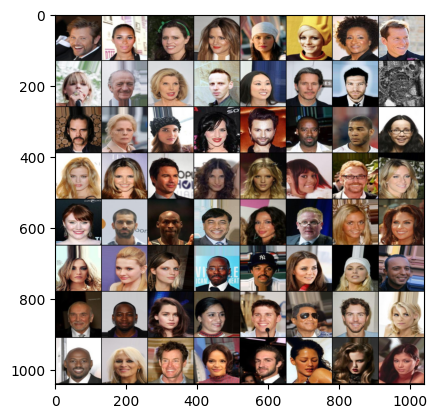

["The man has pretty high cheekbones. He sports a 5 o' clock shadow. He has brown and straight hair. He has a slightly open mouth. He seems attractive and young is smiling.", 'The lady has an oval face. She has straight and receding hair. She has arched eyebrows, big lips, a big nose, bushy eyebrows and a slightly open mouth. The female seems attractive, young, has rosy cheeks and heavy makeup. She is wearing earrings and lipstick.', 'The female has pretty high cheekbones and an oval face. Her hair is wavy. She has a slightly open mouth. The lady is smiling, looks attractive, young and has heavy makeup. She is wearing lipstick.', 'The female has pretty high cheekbones. She seems attractive, young, is smiling and has heavy makeup. She is wearing lipstick.', 'The lady looks attractive, young and has heavy makeup. She is wearing a hat and lipstick.', 'The woman has pretty high cheekbones. Her hair is blond and straight. She has big lips and a slightly open mouth. The lady seems attractive

In [22]:
images, labels, wrong_images = next(weighted_dataiter)
show_grid(torchvision.utils.make_grid(images, normalize=True))
print(labels)

# Initialize Weights

In [23]:
def initialize_weights(model):
    className = model.__class__.__name__
    if className.find('Conv') != -1:
        nn.init.normal_(model.weight.data, 0.0, 0.02)
    elif className.find('BatchNorm') != -1:
        nn.init.normal_(model.weight.data, 1.0, 0.02)
        nn.init.constant_(model.bias.data, 0)

# Generator Network

Hout = (Hin −1) × stride[0] − 2 × padding[0] + dilation[0] × (kernel_size[0] − 1) + output_padding[0] + 1

Wout = (Win −1) × stride[1] − 2 × padding[1] + dilation[1] × (kernel_size[1] − 1) + output_padding[1] + 1

In [24]:
class Generator(nn.Module):
    '''
    The Generator Network
    '''

    def __init__(self, noise_size, feature_size, num_channels, embedding_size, reduced_dim_size):
        super(Generator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        self.projection = nn.Sequential(
            nn.Linear(in_features = embedding_size, out_features = reduced_dim_size),
            nn.BatchNorm1d(num_features = reduced_dim_size),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True)
        )

        self.layer = nn.Sequential(
            nn.ConvTranspose2d(noise_size + reduced_dim_size, feature_size * 8, 4, 1, 0, bias = False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(negative_slope = 0.2, inplace = True),

            # state size (ngf*4) x 4 x 4
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),

            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),

            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf*2) x 32 x 32
            nn.ConvTranspose2d(feature_size, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),

            # state size. (ngf) x 64 x 64
            nn.ConvTranspose2d(feature_size, num_channels, 4, 2, 1, bias=False),
            nn.Tanh()

        )
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0002, betas = (0.5, 0.5))

    def forward(self, noise, text_embeddings):
        encoded_text = self.projection(text_embeddings)
        concat_input = torch.cat([noise, encoded_text], dim = 1).unsqueeze(2).unsqueeze(2)
        output = self.layer(concat_input)
        return output

In [25]:
generator = Generator(cfg.noise_size, cfg.image_size, cfg.num_channels, 768, 256)
generator.apply(initialize_weights)
generator.cuda()

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

##### Test output shape of Generator

torch.Size([64, 3, 128, 128])


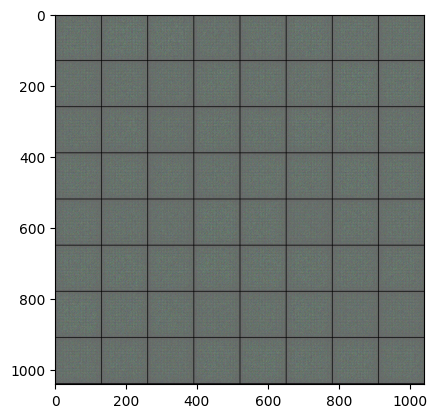

Generator(
  (projection): Sequential(
    (0): Linear(in_features=768, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
  )
  (layer): Sequential(
    (0): ConvTranspose2d(356, 1024, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(1024, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2),

In [26]:
with torch.no_grad():
  generator.eval()
  noise = torch.randn(size=(cfg.batch_size, cfg.noise_size)).cuda()
  text_embeddings = sentence_encoder.convert_text_to_embeddings(labels)
  output = generator(noise, text_embeddings).detach()
  print(output.shape)
show_grid(torchvision.utils.make_grid(output.cpu(), normalize=True))
generator.train()

# Discriminator Network

Hout = ( (Hin + 2 × padding[0] − dilation[0] × (kernel_size[0] − 1) - 1) / stride[0]) + 1

Wout = ( (Win + 2 × padding[1] − dilation[1] × (kernel_size[1] − 1) - 1) / stride[1]) + 1


In [27]:
class Discriminator(nn.Module):
    '''
    The Discriminator Network
    '''

    def __init__(self, num_channels, feature_size, embedding_size, reduced_dim_size):
        super(Discriminator, self).__init__()
        self.reduced_dim_size = reduced_dim_size

        ## Image Encoder
        self.netD_1 = nn.Sequential(
            # input nc x 128 x 128
            nn.Conv2d(num_channels, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # input nc x 64 x 64
            nn.Conv2d(feature_size, feature_size, 4, 2, 1, bias = False),
            nn.LeakyReLU(0.2, inplace = True),

            # state size ndf x 32 x 32
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias = False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace = True),

            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),

            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),

        )

        ## Text Encoder
        self.projector = nn.Sequential(
            nn.Linear(in_features=embedding_size, out_features=reduced_dim_size),
            nn.BatchNorm1d(num_features=reduced_dim_size),
            nn.LeakyReLU(negative_slope=0.2, inplace=True)
        )

        ## Text + Image Concat Layer
        self.netD_2 = nn.Sequential(
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(feature_size * 8 + reduced_dim_size, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.0001, betas = (0.5, 0.5))

    def forward(self, input_img, text_embeddings):
        x_intermediate = self.netD_1(input_img)

        projected_embed = self.projector(text_embeddings)

        replicated_embed = projected_embed.repeat(4, 4, 1, 1).permute(2,  3, 0, 1)
        hidden_concat = torch.cat([x_intermediate, replicated_embed], 1)

        x = self.netD_2(hidden_concat)

        return x.view(-1, 1), x_intermediate

In [28]:
discriminator = Discriminator(cfg.num_channels, cfg.image_size, 768, 256)
discriminator.apply(initialize_weights)
discriminator.cuda()

Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

##### Test output shape of Discriminator

In [29]:
with torch.no_grad():
  discriminator.eval()
  validity, _ = discriminator(output, text_embeddings)
  print(validity.shape)
discriminator.train()

torch.Size([64, 1])


Discriminator(
  (netD_1): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): LeakyReLU(negative_slope=0.2, inplace=True)
    (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (5): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): LeakyReLU(negative_slope=0.2, inplace=True)
    (7): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (8): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): LeakyReLU(negative_slope=0.2, inplace=True)
    (10): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (11): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): LeakyReLU(negative_slo

#### Specifying Loss Functions

In [30]:
criterion = nn.BCELoss().cuda()
l2_loss = nn.MSELoss().cuda()
l1_loss = nn.L1Loss().cuda()

This is just to generate a batch of text embeddings to be used to plot

In [31]:
plt_images, plt_labels, _ = next(weighted_dataiter)
plt_o_text_embeddings = sentence_encoder.convert_text_to_embeddings(plt_labels)
plt_o_text_embeddings.shape

torch.Size([64, 768])

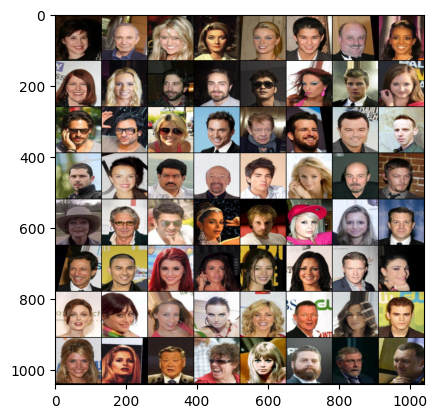

['She has brown hair. She has a slightly open mouth. The lady is young and is smiling.', 'The male is chubby, has a double chin and pretty high cheekbones. He has gray, receding hair and he is partially bald. He has a big nose. He is smiling. He is wearing a necktie.', 'The lady has high cheekbones. She has blond and wavy hair. She has arched eyebrows and a slightly open mouth. She is smiling, is attractive, young and has heavy makeup. She is wearing earrings, lipstick and a necklace.', 'The lady has high cheekbones and an oval face. She has wavy hair. She has arched eyebrows. The lady is attractive, young and has heavy makeup. She is wearing lipstick.', 'The woman has high cheekbones and an oval face. Her hair is blond. She has arched eyebrows, big lips, a slightly open mouth and a pointy nose. The female is attractive, young, is smiling, has rosy cheeks and heavy makeup. She is wearing earrings, lipstick and a necklace.', 'The man has high cheekbones. He has black and straight hair. 

In [32]:
show_grid(torchvision.utils.make_grid(plt_images.cpu(), normalize=True))
print(plt_labels)

In [33]:
fixed_noise = torch.randn(size=(len(plt_labels), cfg.noise_size)).cuda()

In [34]:
def plot_output(epoch):
  plt.clf()
  with torch.no_grad():

    generator.eval()
    test_images = generator(fixed_noise, plt_o_text_embeddings)
    generator.train()

    grid = torchvision.utils.make_grid(test_images.cpu(), normalize=True)
    show_grid(grid)

  wandb.log({'output': wandb.Image(grid, caption=f'Output for epoch: {epoch}')}, step=epoch)

# Training

0it [00:00, ?it/s]

Epoch:  1 / 10
Discriminator Loss: 3.605, Generator Loss: 30.839


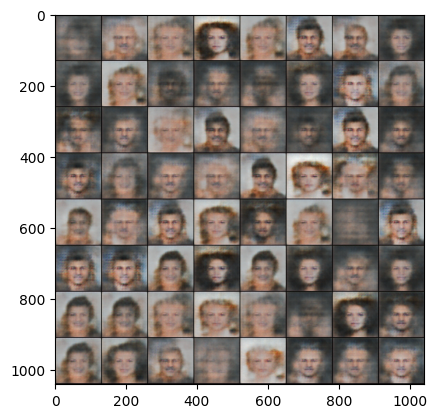

Epoch:  2 / 10
Discriminator Loss: 1.858, Generator Loss: 27.769


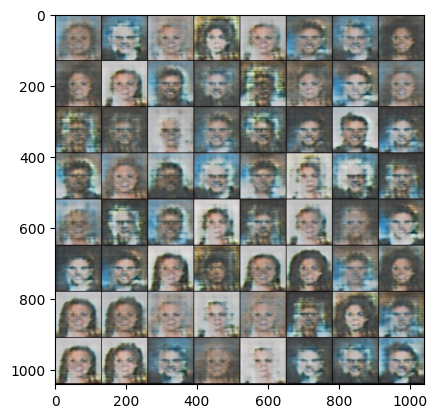

Epoch:  3 / 10
Discriminator Loss: 1.804, Generator Loss: 27.662


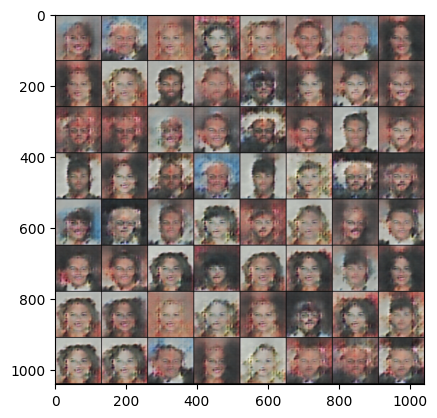

Epoch:  4 / 10
Discriminator Loss: 1.776, Generator Loss: 27.658


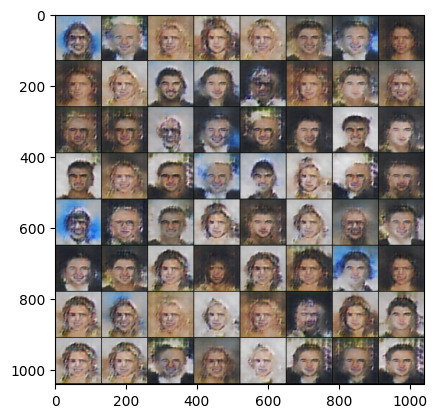

Epoch:  5 / 10
Discriminator Loss: 1.751, Generator Loss: 27.655


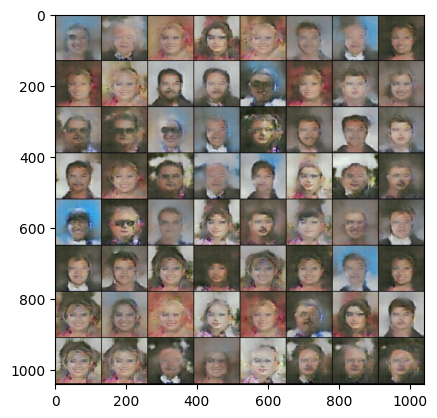

Epoch:  6 / 10
Discriminator Loss: 1.753, Generator Loss: 27.430


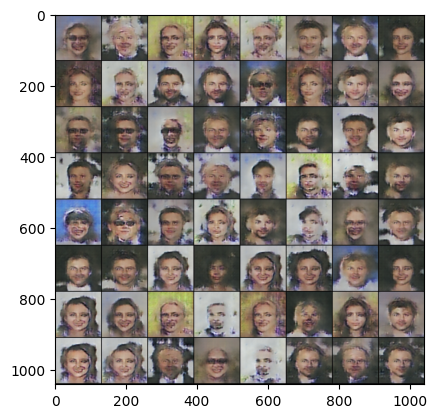

Epoch:  7 / 10
Discriminator Loss: 1.726, Generator Loss: 27.443


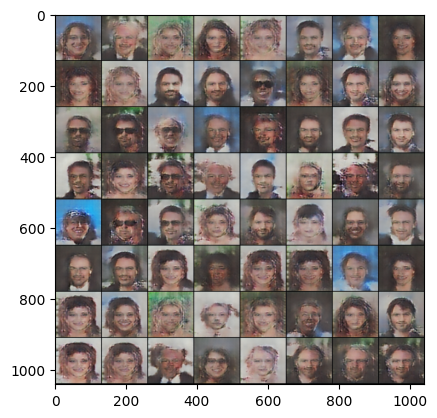

Epoch:  8 / 10
Discriminator Loss: 1.733, Generator Loss: 27.387


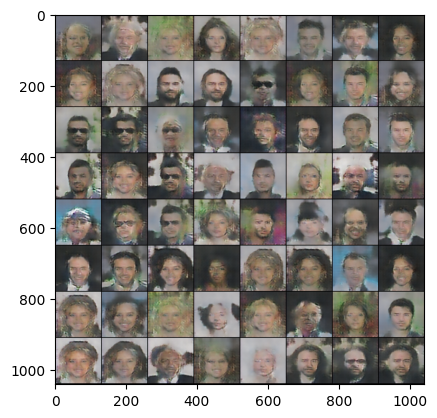

Epoch:  9 / 10
Discriminator Loss: 1.709, Generator Loss: 27.334


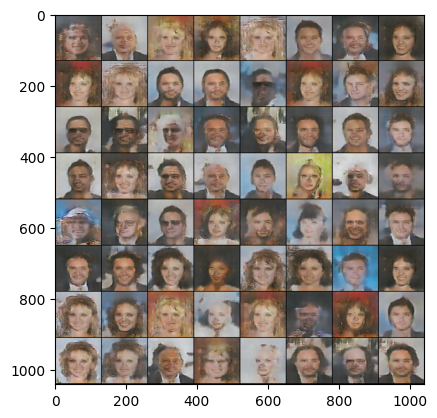

Epoch:  10 / 10
Discriminator Loss: 1.717, Generator Loss: 27.317


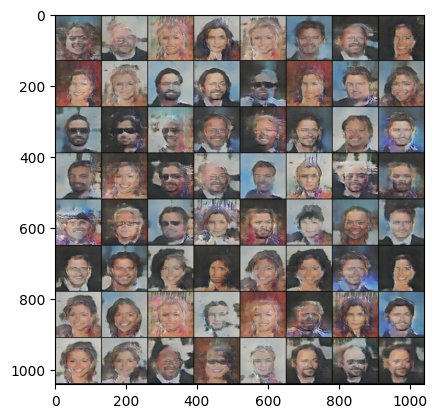

True

In [35]:
pbar = tqdm()

wandb.watch(generator)
wandb.watch(discriminator)

for epoch in range(cfg.epochs):
    print(f'Epoch:  {epoch + 1} / {cfg.epochs}')
    pbar.reset(total = len(weighted_dataloader))

    discriminator_loss = []
    generator_loss = []

    for i, (real_images, real_text, wrong_images) in enumerate(weighted_dataloader):
        current_batch_size = real_images.size()[0]

        #converting to cuda
        real_images = real_images.cuda()
        text_embeddings = sentence_encoder.convert_text_to_embeddings(real_text)
        wrong_images = wrong_images.cuda()

        real_validity = torch.ones(current_batch_size, 1).cuda()
        fake_validity = torch.zeros(current_batch_size, 1).cuda()

        temp_tensor = (torch.ones(current_batch_size, 1).cuda()) * (-0.1)
        smoothed_real_labels = torch.add(real_validity, temp_tensor)

        ## Training the discriminator
        discriminator.zero_grad()
        output, activation_real = discriminator(real_images, text_embeddings)
        real_loss = criterion(output, smoothed_real_labels)
        real_score = output

        output, _ = discriminator(wrong_images, text_embeddings)
        wrong_loss = criterion(output, fake_validity)

        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, _ = discriminator(fake_images, text_embeddings)
        fake_loss = criterion(output, fake_validity)

        d_loss = real_loss + wrong_loss + fake_loss

        d_loss.backward()
        discriminator.optimizer.step()
        discriminator_loss.append(d_loss)

        ## Training generator
        generator.zero_grad()
        input_noise = torch.randn(size=(current_batch_size, cfg.noise_size)).cuda()
        fake_images = generator(input_noise, text_embeddings)
        output, activation_fake = discriminator(fake_images, text_embeddings)
        _, activation_real = discriminator(real_images, text_embeddings)

        activation_fake = torch.mean(activation_fake, 0)    #try with median and check if it converges
        activation_real = torch.mean(activation_real, 0)    #try with median and check if it converges

        g_loss = criterion(output, real_validity) + 100 * l2_loss(activation_fake, activation_real.detach()) + 50 * l1_loss(fake_images, real_images)

        g_loss.backward()
        generator.optimizer.step()
        generator_loss.append(g_loss)

        pbar.update()

    print('Discriminator Loss: {:.3f}, Generator Loss: {:.3f}'.format(
          torch.mean(torch.FloatTensor(discriminator_loss)),
          torch.mean(torch.FloatTensor(generator_loss))

  ))

    wandb.log({"generator loss" : torch.mean(torch.FloatTensor(generator_loss)), "discriminator loss" : torch.mean(torch.FloatTensor(discriminator_loss))}, step=epoch+1)

    if (epoch + 1) % 1 == 0:
      plot_output(epoch + 1)

pbar.refresh()

# Output

In [36]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The man is chubby, has a double chin and pretty high cheekbones. He grows a sideburns. His hair is gray and receding. He has big lips and a big nose. The man looks young.'])

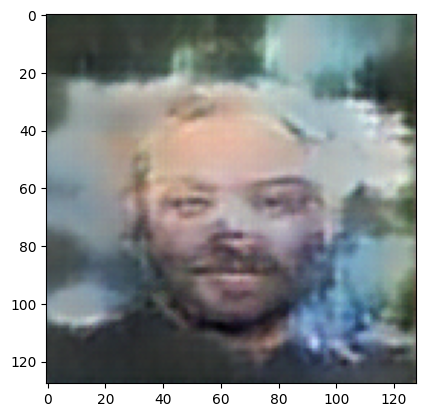

In [37]:
generator.eval()
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))

In [38]:
test_noise = torch.randn(size=(1, cfg.noise_size)).cuda()
test_embeddings = sentence_encoder.convert_text_to_embeddings(['The female has pretty high cheekbones and an oval face. Her hair is black. She has a slightly open mouth and a pointy nose. The female is smiling, looks attractive and has heavy makeup. She is wearing earrings and lipstick.'])

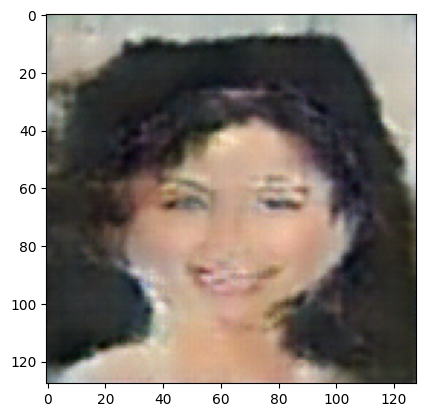

In [39]:
test_image = generator(test_noise, test_embeddings).detach().cpu()
show_grid(torchvision.utils.make_grid(test_image, normalize=True, nrow=1))